In [2]:
"""Reference: https://github.com/nagypeterjob/Sentiment-Analysis-NLTK-ML-LSTM/blob/master/lstm.ipynb"""

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import importlib
import utils
import models

from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, CuDNNLSTM, CuDNNGRU, LSTM, GRU, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re
import zipfile

importlib.reload(utils)
importlib.reload(models)

<module 'models' from '/home/jerrysong/w266-Final-project/jerry/models.py'>

Only keeping the needed columns.

In [3]:
train_data = pd.read_csv('../data/sentiment140_train.zip', encoding='ISO-8859-1', header=None, names=['sentiment','id','timestamp','type','user','text'])
test_data = pd.read_csv('../data/sentiment140_test.zip', encoding='ISO-8859-1', header=None, names=['sentiment','id','timestamp','type','user','text'])

# The original training data are sorted by sentiment value. Shuffle the training data for randomness
train_data = train_data[['text','sentiment']].sample(frac=1, random_state=40)
test_data = test_data[['text','sentiment']]

In [3]:
utils.preprocess(train_data)
utils.preprocess(test_data)

In [4]:
train_data.dtypes

text         object
sentiment     int64
dtype: object

In [5]:
train_data.head(10)

,text,sentiment
551218,i dont want to leave,0
1512535,good nite all sleep tight dont let the bed bug...,4
1295295,its a beautiful day guess whos going to see uD...,4
893979,yay for ikea swedish meatballs,4
279338,and god knows how many more singstar and buzz ...,0
886145,rosie_edward thanks you so much for following ...,4
1504955,good morning all hope ur day started well,4
728643,so bored weekend is almost over,0
1005200,carlaloo jajanika found our entry woohoo check...,4
1148569,ooh look who seems to be working tonight way t...,4


In [6]:
train_data['sentiment'].unique()

array([0, 4])

In [7]:
vocabulary = utils.get_corpus_vocabulary(train_data)

Plot the word count histogram of the training data

[1, 1, 1, 2, 2, 2, 3, 3, 4, 4, 5, 5, 6, 7, 8, 9, 9, 10, 11, 12, 14, 15, 16, 17, 19, 20, 22, 24, 26, 28, 30, 33, 35, 38, 41, 44, 47, 51, 55, 59, 63, 68, 73, 78, 83, 89, 95, 102, 109, 117, 125, 134, 143, 154, 167, 180, 194, 210, 227, 245, 265, 287, 310, 335, 363, 392, 426, 464, 506, 554, 608, 668, 736, 815, 906, 1011, 1133, 1277, 1445, 1643, 1878, 2163, 2508, 2930, 3459, 4132, 5006, 6160, 7727, 9966, 13383, 18923, 28375, 45063, 75112, 129493, 223083, 402773, 611300, 819826]


<BarContainer object of 100 artists>

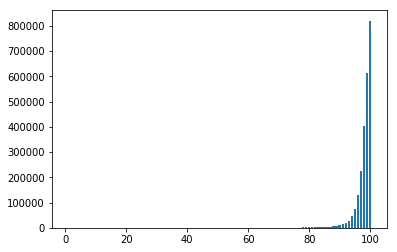

In [8]:
corpus_total_cnt = sum(vocabulary.values())
sorted_by_wd_cnt = sorted(((cnt, wd) for wd, cnt in vocabulary.items()), reverse=True)

plt_points = []
accu = 0
j = 0
for i in range(1, 101):
    while accu < (corpus_total_cnt * i / 100.0):
        accu += sorted_by_wd_cnt[j][0]
        j += 1
    plt_points.append(j)
    
print(plt_points)
plt.bar(range(1, 101), plt_points)

The top 10000 words account for 90% word occurance of the entire corpus.

In [9]:
print('The size of the training corpus: {}'.format(len(vocabulary)))
print('The top 10 words are: {}'.format(sorted_by_wd_cnt[:10]))
print('The least 10 words are: {}'.format(sorted_by_wd_cnt[-10:]))

The size of the training corpus: 819826
The top 10 words are: [(750807, 'i'), (564547, 'to'), (520035, 'the'), (377569, 'a'), (314054, 'my'), (298347, 'and'), (270065, 'you'), (236007, 'is'), (230839, 'it'), (215690, 'for')]
The least 10 words are: [(1, 'DG_DGmagazine'), (1, 'DG_DGchick'), (1, 'DG_DG_manytweets'), (1, 'DG_DG_hustle_ent'), (1, 'DG_'), (1, 'DG^o'), (1, 'DG^eDG'), (1, 'DG^c'), (1, 'DG^'), (1, 'DG\\quot')]


In [10]:
test_data.head(10)

,text,sentiment
0,stellargirl i loooooooovvvvvveee my kindleDG n...,4
1,reading my kindleDG love it lee childs is goo...,4
2,ok first assesment of the kindleDG it fucking ...,4
3,kenburbary youll love your kindleDG ive had mi...,4
4,mikefish fair enough but i have the kindleDG ...,4
5,richardebaker no it is too big im quite happy ...,4
6,fuck this economy i hate aig and their non loa...,0
7,jquery is my new best friend,4
8,loves twitter,4
9,how can you not love obama he makes jokes abou...,4


In [11]:
test_data['sentiment'].unique()

array([4, 0, 2])

Remove rows with neural sentiment score from the test data, since they don't exist in the train data

In [4]:
test_data = test_data[test_data['sentiment'].isin([0, 4])]
test_data['sentiment'].unique()

array([4, 0])

In [13]:
print('Positive rows: {}'.format(train_data[ train_data['sentiment'] == 4]['sentiment'].size))
print('Negative rows: {}'.format(train_data[ train_data['sentiment'] == 0]['sentiment'].size))

Positive rows: 800000
Negative rows: 800000


In [5]:
# Only keep top 10000 words in the vocabulary.
max_fatures = 10000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(train_data['text'].values)

In [6]:
X_train = tokenizer.texts_to_sequences(train_data['text'].values)
X_train = pad_sequences(X_train)

X_test = tokenizer.texts_to_sequences(test_data['text'].values)
X_test = pad_sequences(X_test, maxlen=X_train.shape[1])

In [16]:
print('The shape of X_train: {}'.format(X_train.shape))
print('The shape of X_test: {}'.format(X_test.shape))

The shape of X_train: (1600000, 40)
The shape of X_test: (359, 40)


In [17]:
print(X_train[0])
print(X_test[0])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1
  40  70   2 343]
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    1    5   26   19    3
 9685    8  196   20    3   12    8 1010   11   25  485  112]


In [7]:
Y_train = pd.get_dummies(train_data['sentiment']).values
Y_test = pd.get_dummies(test_data['sentiment']).values
print('The shape of Y_train: {}'.format(Y_train.shape))
print('The shape of Y_test: {}'.format(Y_test.shape))

The shape of Y_train: (1600000, 2)
The shape of Y_test: (359, 2)


In [19]:
print(Y_train[:10])
print(Y_test[:10])

[[1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]]
[[0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]]


In [8]:
size_limit = len(X_train)
X_train_sample, Y_train_sample = X_train[:size_limit], Y_train[:size_limit]

We should explore LSTM, CuDNNLSTM, GRU, CuDNNGRU cells. CuDNN cells have following limitations: 1. The activation function has to be `tanh`. 2. It doesn't support dropout.

In [12]:
# Hyperparameters tuning for LSTM: https://arxiv.org/pdf/1707.06799.pdf
embed_dim = 200
lstm_out = 100
input_length = X_train.shape[1]
epochs = 6
batch_size = 256
# Why 0.5: https://www.reddit.com/r/MachineLearning/comments/3oztvk/why_50_when_using_dropout/
# Variational Dropout: https://arxiv.org/pdf/1512.05287.pdf
input_dropout = 0.5
recurrent_dropout = 0.5
embedding_layer = Embedding(max_fatures, embed_dim, input_length=input_length)

## CuDNNLSTM Baseline

In [22]:
params = {
    'model_type': CuDNNLSTM,
    'batch_size': 256,
    'embedding_type': 'randomly initialized',
    'embedding_dim': 200,
    'embedding_max_features': 10000,
    'embedding_word_index': None,
    'embedding_pretrained_zip_path': None,
    'embedding_pretrained_name': None,
    'epoch': 6,
    'rnn_dim': 100,
    'rnn_layer_num': 1,
    'input_length': X_train_sample.shape[1],
    'input_dropout': 0.5,
    'recurrent_dropout': None,
    'optimizer': 'adam',
    'activation': 'sigmoid',
    'loss': 'binary_crossentropy',
}

model = models.get_model(params)
history = model.fit(
    X_train_sample, Y_train_sample, epochs=params['epoch'], batch_size=params['batch_size'], verbose=2, validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 40, 200)           2000000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 40, 200)           0         
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 100)               120800    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 202       
Total params: 2,121,002
Trainable params: 2,121,002
Non-trainable params: 0
_________________________________________________________________
None
Train on 1280000 samples, validate on 320000 samples
Epoch 1/6
 - 105s - loss: 0.4285 - acc: 0.8011 - val_loss: 0.4024 - val_acc: 0.8161
Epoch 2/6
 - 99s - loss: 0.3948 - acc: 0.8202 - val_loss: 0.3925 - val_acc: 0.8217
Epoch 3/6
 - 99s - loss: 0.3806 - acc: 

The model becomes overfitting very fast with more epochs. A smaller epoch should be better.

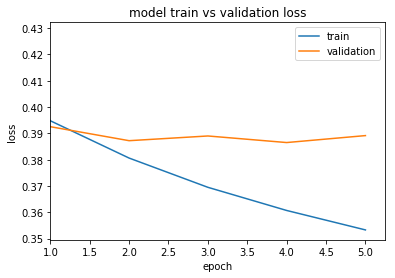

score: 0.37376496
acc: 0.82729805


In [24]:
models.plot_model_train_history(history)
score, acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.8f" % (score))
print("acc: %.8f" % (acc))

## CuDNNLSTM with 5 Epochs

In [25]:
params = {
    'model_type': CuDNNLSTM,
    'batch_size': 256,
    'embedding_type': 'randomly initialized',
    'embedding_dim': 200,
    'embedding_max_features': 10000,
    'embedding_word_index': None,
    'embedding_pretrained_zip_path': None,
    'embedding_pretrained_name': None,
    'epoch': 5,
    'rnn_dim': 100,
    'rnn_layer_num': 1,
    'input_length': X_train_sample.shape[1],
    'input_dropout': 0.5,
    'recurrent_dropout': None,
    'optimizer': 'adam',
    'activation': 'sigmoid',
    'loss': 'binary_crossentropy',
}

model = models.get_model(params)
history = model.fit(
    X_train_sample, Y_train_sample, epochs=params['epoch'], batch_size=params['batch_size'], verbose=2, validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 40, 200)           2000000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 40, 200)           0         
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 100)               120800    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 2,121,002
Trainable params: 2,121,002
Non-trainable params: 0
_________________________________________________________________
None
Train on 1280000 samples, validate on 320000 samples
Epoch 1/5
 - 100s - loss: 0.4281 - acc: 0.8014 - val_loss: 0.4023 - val_acc: 0.8160
Epoch 2/5
 - 100s - loss: 0.3943 - acc: 0.8207 - val_loss: 0.3914 - val_acc: 0.8218
Epoch 3/5
 - 100s - loss: 0.3802 - acc

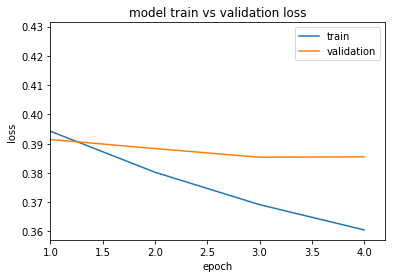

score: 0.39043422
acc: 0.82311978


In [27]:
models.plot_model_train_history(history)
score, acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.8f" % (score))
print("acc: %.8f" % (acc))

## CuDNNLSTM with 5 Epochs and 2 LSTM Layers

In [29]:
params = {
    'model_type': CuDNNLSTM,
    'batch_size': 256,
    'embedding_type': 'randomly initialized',
    'embedding_dim': 200,
    'embedding_max_features': 10000,
    'embedding_word_index': None,
    'embedding_pretrained_zip_path': None,
    'embedding_pretrained_name': None,
    'epoch': 5,
    'rnn_dim': 100,
    'rnn_layer_num': 2,
    'input_length': X_train_sample.shape[1],
    'input_dropout': 0.5,
    'recurrent_dropout': None,
    'optimizer': 'adam',
    'activation': 'sigmoid',
    'loss': 'binary_crossentropy',
}

model = models.get_model(params)
history = model.fit(
    X_train_sample, Y_train_sample, epochs=params['epoch'], batch_size=params['batch_size'], verbose=2, validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 40, 200)           2000000   
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 40, 200)           0         
_________________________________________________________________
cu_dnnlstm_5 (CuDNNLSTM)     (None, 40, 100)           120800    
_________________________________________________________________
cu_dnnlstm_6 (CuDNNLSTM)     (None, 100)               80800     
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 202       
Total params: 2,201,802
Trainable params: 2,201,802
Non-trainable params: 0
_________________________________________________________________
None
Train on 1280000 samples, validate on 320000 samples
Epoch 1/5
 - 160s - loss: 0.4274 - acc: 0.8015 - val_loss: 0.4013 - val_ac

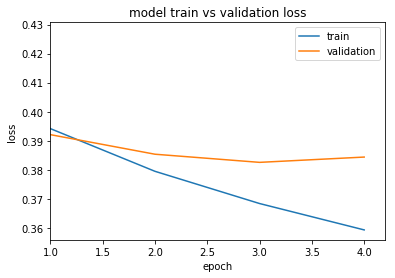

score: 0.39044503
acc: 0.81894150


In [30]:
models.plot_model_train_history(history)
score, acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.8f" % (score))
print("acc: %.8f" % (acc))

## CuDNNGRU with 5 Epochs

In [31]:
params = {
    'model_type': CuDNNGRU,
    'batch_size': 256,
    'embedding_type': 'randomly initialized',
    'embedding_dim': 200,
    'embedding_max_features': 10000,
    'embedding_word_index': None,
    'embedding_pretrained_zip_path': None,
    'embedding_pretrained_name': None,
    'epoch': 5,
    'rnn_dim': 100,
    'rnn_layer_num': 1,
    'input_length': X_train_sample.shape[1],
    'input_dropout': 0.5,
    'recurrent_dropout': None,
    'optimizer': 'adam',
    'activation': 'sigmoid',
    'loss': 'binary_crossentropy',
}

model = models.get_model(params)
history = model.fit(
    X_train_sample, Y_train_sample, epochs=params['epoch'], batch_size=params['batch_size'], verbose=2, validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 40, 200)           2000000   
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 40, 200)           0         
_________________________________________________________________
cu_dnngru_1 (CuDNNGRU)       (None, 100)               90600     
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 202       
Total params: 2,090,802
Trainable params: 2,090,802
Non-trainable params: 0
_________________________________________________________________
None
Train on 1280000 samples, validate on 320000 samples
Epoch 1/5
 - 93s - loss: 0.4287 - acc: 0.8012 - val_loss: 0.4021 - val_acc: 0.8166
Epoch 2/5
 - 92s - loss: 0.3942 - acc: 0.8209 - val_loss: 0.3913 - val_acc: 0.8220
Epoch 3/5
 - 92s - loss: 0.3803 - acc: 0

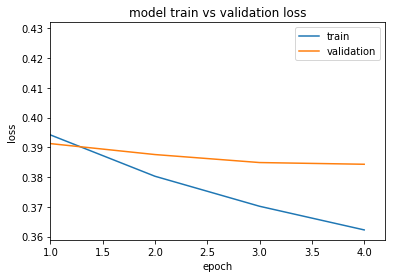

score: 0.39041958
acc: 0.81197772


In [32]:
models.plot_model_train_history(history)
score, acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.8f" % (score))
print("acc: %.8f" % (acc))

## LSTM with 5 Epochs and 0.5 Recurrent Dropout

In [33]:
params = {
    'model_type': LSTM,
    'batch_size': 256,
    'embedding_type': 'randomly initialized',
    'embedding_dim': 200,
    'embedding_max_features': 10000,
    'embedding_word_index': None,
    'embedding_pretrained_zip_path': None,
    'embedding_pretrained_name': None,
    'epoch': 5,
    'rnn_dim': 100,
    'rnn_layer_num': 1,
    'input_length': X_train_sample.shape[1],
    'input_dropout': 0.5,
    'recurrent_dropout': 0.5,
    'optimizer': 'adam',
    'activation': 'sigmoid',
    'loss': 'binary_crossentropy',
}

model = models.get_model(params)
history = model.fit(
    X_train_sample, Y_train_sample, epochs=params['epoch'], batch_size=params['batch_size'], verbose=2, validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 40, 200)           2000000   
_________________________________________________________________
spatial_dropout1d_6 (Spatial (None, 40, 200)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               120400    
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 202       
Total params: 2,120,602
Trainable params: 2,120,602
Non-trainable params: 0
_________________________________________________________________
None
Train on 1280000 samples, validate on 320000 samples
Epoch 1/5
 - 499s - loss: 0.4351 - acc: 0.7977 - val_loss: 0.4060 - val_acc: 0.8139
Epoch 2/5
 - 500s - loss: 0.4013 - acc: 0.8168 - val_loss: 0.3977 - val_acc: 0.8193
Epoch 3/5
 - 495s - loss: 0.3884 - acc

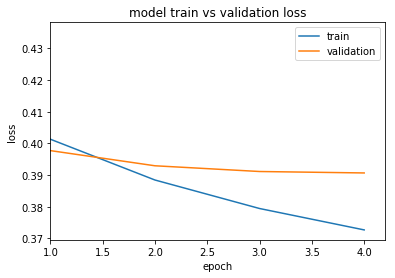

score: 0.37285437
acc: 0.82729806


In [34]:
models.plot_model_train_history(history)
score, acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.8f" % (score))
print("acc: %.8f" % (acc))

## CuDNNLSTM with 5 Epochs and Glove Embedding

In [10]:
# Skip customized data preprocessing when use pre-trained embedding

params = {
    'model_type': CuDNNLSTM,
    'batch_size': 256,
    'embedding_type': 'randomly initialized',
    'embedding_dim': 200,
    'embedding_max_features': 20000,
    'embedding_word_index': tokenizer.word_index,
    'embedding_pretrained_zip_path': '../glove.twitter.27B.zip',
    'embedding_pretrained_name': 'glove.twitter.27B.200d.txt',
    'epoch': 5,
    'rnn_dim': 100,
    'rnn_layer_num': 1,
    'input_length': X_train_sample.shape[1],
    'input_dropout': 0.5,
    'recurrent_dropout': 0.5,
    'optimizer': 'adam',
    'activation': 'sigmoid',
    'loss': 'binary_crossentropy',
}

model = models.get_model(params)
history = model.fit(
    X_train_sample, Y_train_sample, epochs=params['epoch'], batch_size=params['batch_size'], verbose=2, validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 117, 200)          4000000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 117, 200)          0         
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 100)               120800    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 4,121,002
Trainable params: 4,121,002
Non-trainable params: 0
_________________________________________________________________
None
Train on 1280000 samples, validate on 320000 samples
Epoch 1/5
 - 238s - loss: 0.4194 - acc: 0.8068 - val_loss: 0.3906 - val_acc: 0.8228
Epoch 2/5
 - 238s - loss: 0.3803 - acc: 0.8285 - val_loss: 0.3826 - val_acc: 0.8270
Epoch 3/5
 - 239s - loss: 0.3628 - acc

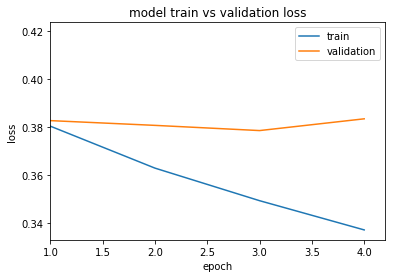

score: 0.42819649
acc: 0.80501394


In [15]:
models.plot_model_train_history(history)
score, acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = 256)
print("score: %.8f" % (score))
print("acc: %.8f" % (acc))

Extracting a validation set, and measuring score and accuracy.

To improve:
1. The model is suffering from overfitting. We should add more dropout layers and try other regularization methods.
2. Systematically search for the optimal combination of hyperparameters
3. Try pretrained embedding, bidirectional RNN, combination of word and character level embedding (https://papers.nips.cc/paper/5782-character-level-convolutional-networks-for-text-classification.pdf)